## Examining regression models

1. Trying to see if any regression models can be used to predict "Min Delay" based on all the other parameters.
2. Based on models examined in class and advice from Learning Support, decided to test "Linear Regression", "KNN Regression", and "XGB Regression".
3. Built a Pipeline to concurrently test "Linear", "Ridge", "Lasso", "Random Forest" and "XBG" Regressions.
4. Tested this Pipeline with data with and without "Min Gap" to examine how strongly that parameter correlates with "Min Delay" and how hard it is to find a regression model that fits "Min Delay" without "Min Gap".



In [2]:
# Import necessary librarys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
from xgboost import XGBRegressor

# Output dataframes instead of arrays
set_config(transform_output="pandas")

In [3]:
# Reading cleaned ttc data in excel file format and examining it
ttc = pd.read_csv('ttc-streetcar-delay-data-2024_cleaned.csv')
ttc


,Date,Line,Time,Day,Location,Incident,Min Delay,Min Gap,Bound,Vehicle,Month,Week,Day of Month,Hour of Day,Season
0,28-Apr-24,301.0,03:54,Sunday,WOLSELEY LOOP,Cleaning - Unsanitary,30.0,60.0,E,8118.0,4.0,18.0,28.0,3.0,Spring
1,14-Sep-24,301.0,02:23,Saturday,WOLSELEY LOOP,Utilized Off Route,30.0,60.0,W,8112.0,9.0,37.0,14.0,2.0,Summer
2,28-Jan-24,301.0,02:11,Sunday,WARDEN AND COMSTOCK,Mechanical,10.0,20.0,W,8734.0,1.0,5.0,28.0,2.0,Winter
3,15-Nov-24,301.0,02:35,Friday,THE QUEENSWAY AND WIND,Security,24.0,39.0,W,4588.0,11.0,46.0,15.0,2.0,Fall
4,25-Aug-24,301.0,03:11,Sunday,THE QUEENSWAY AND GLEN,Mechanical,10.0,30.0,E,4569.0,8.0,35.0,25.0,3.0,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13920,18-Feb-24,512.0,19:50,Sunday,AND KEELE,Operations,8.0,15.0,E,8337.0,2.0,8.0,18.0,19.0,Winter
13921,19-Apr-24,512.0,20:24,Friday,AND GLENHOLME,Mechanical,10.0,20.0,W,8799.0,4.0,16.0,19.0,20.0,Spring
13922,20-Feb-24,512.0,16:20,Tuesday,AND EARLS COU,Collision - TTC Involved,4.0,8.0,E,8295.0,2.0,8.0,20.0,16.0,Winter
13923,13-May-24,512.0,16:17,Monday,AND DEER PARK,Operations,5.0,10.0,E,8860.0,5.0,20.0,13.0,16.0,Spring


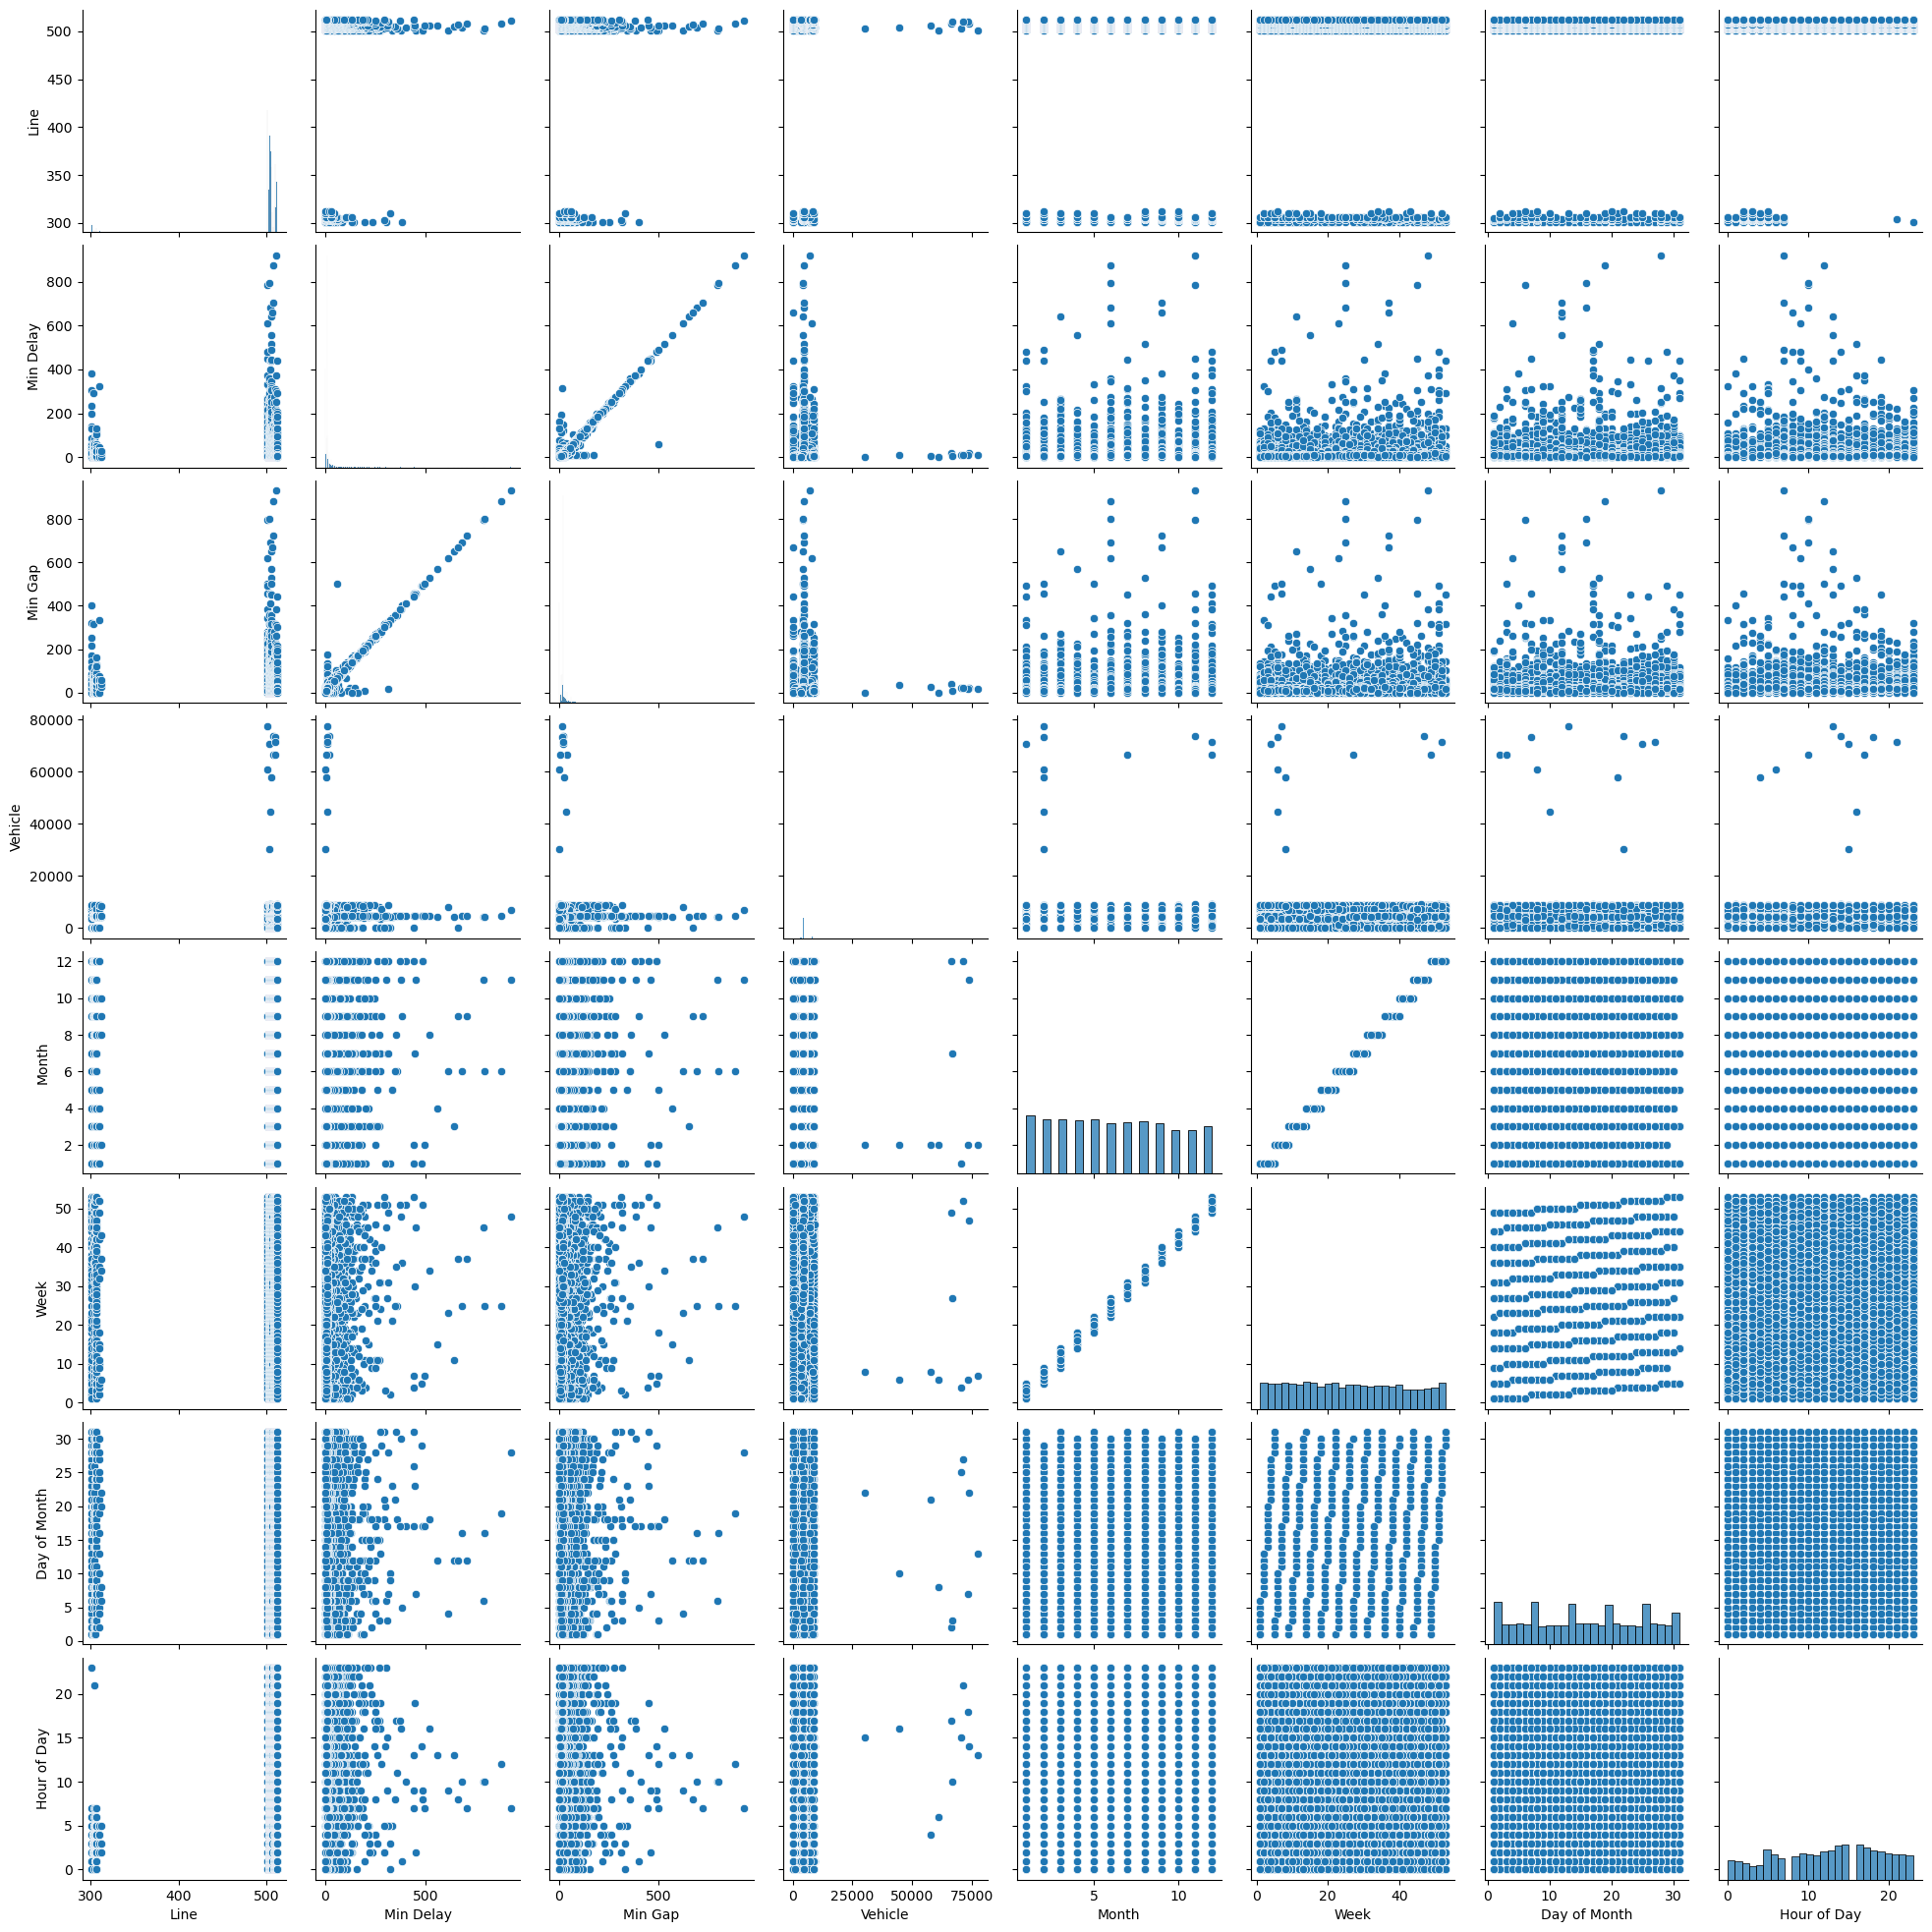

In [4]:
# Overview of (numerical) data.  Looking for any obvious correlations.  Only strong correlations are observed between Min Gap and Min Delay.
sns.pairplot(ttc)

In [5]:
# In our initial data cleaning and enhancing, we noticed that the "Location" data was too messy to be useful and decided to drop if from the analysis.
# We are also dropping "Date" and "Time", since these metrics are better assessed by the parameters "Month", "Week", "Day of Month", and "Hour of Day"
# We are dropping "Bound" since it has over 2000 rows with missing data and we don't expect it to be a strong predictor of delay.

post_cleaning = ttc.drop(columns=['Date', 'Time', 'Location', 'Bound']).dropna()
post_cleaning.head()

,Line,Day,Incident,Min Delay,Min Gap,Vehicle,Month,Week,Day of Month,Hour of Day,Season
0,301.0,Sunday,Cleaning - Unsanitary,30.0,60.0,8118.0,4.0,18.0,28.0,3.0,Spring
1,301.0,Saturday,Utilized Off Route,30.0,60.0,8112.0,9.0,37.0,14.0,2.0,Summer
2,301.0,Sunday,Mechanical,10.0,20.0,8734.0,1.0,5.0,28.0,2.0,Winter
3,301.0,Friday,Security,24.0,39.0,4588.0,11.0,46.0,15.0,2.0,Fall
4,301.0,Sunday,Mechanical,10.0,30.0,4569.0,8.0,35.0,25.0,3.0,Summer


In [6]:
# Encode the categorical variables using One Hot Encoder.

encoded_df = pd.get_dummies(post_cleaning, columns=['Day', 'Incident', 'Season'], drop_first=False)
encoded_df

,Line,Min Delay,Min Gap,Vehicle,Month,Week,Day of Month,Hour of Day,Day_Friday,Day_Monday,...,Incident_Mechanical,Incident_Operations,Incident_Overhead,Incident_Rail/Switches,Incident_Security,Incident_Utilized Off Route,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,301.0,30.0,60.0,8118.0,4.0,18.0,28.0,3.0,False,False,...,False,False,False,False,False,False,False,True,False,False
1,301.0,30.0,60.0,8112.0,9.0,37.0,14.0,2.0,False,False,...,False,False,False,False,False,True,False,False,True,False
2,301.0,10.0,20.0,8734.0,1.0,5.0,28.0,2.0,False,False,...,True,False,False,False,False,False,False,False,False,True
3,301.0,24.0,39.0,4588.0,11.0,46.0,15.0,2.0,True,False,...,False,False,False,False,True,False,True,False,False,False
4,301.0,10.0,30.0,4569.0,8.0,35.0,25.0,3.0,False,False,...,True,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,512.0,0.0,0.0,7006.0,4.0,17.0,22.0,15.0,False,True,...,False,False,False,False,False,False,False,True,False,False
13920,512.0,8.0,15.0,8337.0,2.0,8.0,18.0,19.0,False,False,...,False,True,False,False,False,False,False,False,False,True
13921,512.0,10.0,20.0,8799.0,4.0,16.0,19.0,20.0,True,False,...,True,False,False,False,False,False,False,True,False,False
13922,512.0,4.0,8.0,8295.0,2.0,8.0,20.0,16.0,False,False,...,False,False,False,False,False,False,False,False,False,True


In [7]:
encoded_df.dtypes

Line                                 float64
Min Delay                            float64
Min Gap                              float64
Vehicle                              float64
Month                                float64
Week                                 float64
Day of Month                         float64
Hour of Day                          float64
Day_Friday                              bool
Day_Monday                              bool
Day_Saturday                            bool
Day_Sunday                              bool
Day_Thursday                            bool
Day_Tuesday                             bool
Day_Wednesday                           bool
Incident_Cleaning - Unsanitary          bool
Incident_Collision - TTC Involved       bool
Incident_Diversion                      bool
Incident_Emergency Services             bool
Incident_General Delay                  bool
Incident_Held By                        bool
Incident_Investigation                  bool
Incident_M

In [8]:
# Scale the numeric features.  Will drop the "Min Delay" column since this is our response variable and we want to maintain accurate units.

numeric_columns = post_cleaning.select_dtypes(include=['int64', 'float64']).columns.drop('Min Delay')

# 2. Initialize the scaler
scaler = StandardScaler()

# 3. Fit and transform only the numeric columns
scaled_features = scaler.fit_transform(post_cleaning[numeric_columns])
scaled_features

,Line,Min Gap,Vehicle,Month,Week,Day of Month,Hour of Day
0,-6.441880,0.996772,1.313837,-0.653381,-0.505506,1.382842,-1.457901
1,-6.441880,0.996772,1.311360,0.801503,0.757619,-0.192976,-1.612052
2,-6.441880,-0.114292,1.568057,-1.526312,-1.369749,1.382842,-1.612052
3,-6.441880,0.413463,-0.142978,1.383457,1.355941,-0.080417,-1.612052
4,-6.441880,0.163474,-0.150820,0.510526,0.624658,1.045167,-1.457901
...,...,...,...,...,...,...,...
13919,0.360073,-0.669824,0.854919,-0.653381,-0.571986,0.707491,0.391909
13920,0.360073,-0.253175,1.404217,-1.235335,-1.170308,0.257258,1.008512
13921,0.360073,-0.114292,1.594882,-0.653381,-0.638466,0.369816,1.162663
13922,0.360073,-0.447611,1.386884,-1.235335,-1.170308,0.482375,0.546060


In [9]:
# Merge the encoded columns and the scaled columns into a single dataframe.

ttc = encoded_df.drop(columns=numeric_columns).reset_index(drop=True)
scaled_features = scaled_features.reset_index(drop=True)

total_ttc = pd.concat([ttc, scaled_features], axis = 1)
total_ttc

,Min Delay,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Incident_Cleaning - Unsanitary,Incident_Collision - TTC Involved,...,Season_Spring,Season_Summer,Season_Winter,Line,Min Gap,Vehicle,Month,Week,Day of Month,Hour of Day
0,30.0,False,False,False,True,False,False,False,True,False,...,True,False,False,-6.441880,0.996772,1.313837,-0.653381,-0.505506,1.382842,-1.457901
1,30.0,False,False,True,False,False,False,False,False,False,...,False,True,False,-6.441880,0.996772,1.311360,0.801503,0.757619,-0.192976,-1.612052
2,10.0,False,False,False,True,False,False,False,False,False,...,False,False,True,-6.441880,-0.114292,1.568057,-1.526312,-1.369749,1.382842,-1.612052
3,24.0,True,False,False,False,False,False,False,False,False,...,False,False,False,-6.441880,0.413463,-0.142978,1.383457,1.355941,-0.080417,-1.612052
4,10.0,False,False,False,True,False,False,False,False,False,...,False,True,False,-6.441880,0.163474,-0.150820,0.510526,0.624658,1.045167,-1.457901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,0.0,False,True,False,False,False,False,False,False,False,...,True,False,False,0.360073,-0.669824,0.854919,-0.653381,-0.571986,0.707491,0.391909
13920,8.0,False,False,False,True,False,False,False,False,False,...,False,False,True,0.360073,-0.253175,1.404217,-1.235335,-1.170308,0.257258,1.008512
13921,10.0,True,False,False,False,False,False,False,False,False,...,True,False,False,0.360073,-0.114292,1.594882,-0.653381,-0.638466,0.369816,1.162663
13922,4.0,False,False,False,False,False,True,False,False,True,...,False,False,True,0.360073,-0.447611,1.386884,-1.235335,-1.170308,0.482375,0.546060


In [10]:
# Define the predictor ("X") variables and the response ("y") variable.
# Using everything except 'Min Delay' as a predictor.  Establishing "Min Delay" as the response.

X = total_ttc.drop(columns= 'Min Delay')
y = total_ttc['Min Delay']

# Setting train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1, shuffle = True)

### KNN Regressor

In [11]:
# Will attempt KNN Regression first.

# Initialize KNN Regressor
knn_regressor = KNeighborsRegressor()

# Define parameter grid for GridSearchCV, or set of values of K we want to explore
param_grid = {
    "n_neighbors": range(1, 40, 1),
}

# Initialize and fit GridSearchCV
ttc_gridsearch = GridSearchCV(
    estimator=knn_regressor,
    param_grid=param_grid,
    cv=5, # Five fold cross validation
    scoring="neg_root_mean_squared_error"
)

# Run GridSearch
ttc_gridsearch.fit(X_train, y_train)

# Retrieve and format results
results_complex = pd.DataFrame(ttc_gridsearch.cv_results_) # After fitting the model, we extract the cross-validation results using 'cv_results_'. 
# This option incl various metrics & parameters tested using the cross-validation process

results_simplified = (
    results_complex[[ # Show only the results for "param_n_neighbors" & "mean_test_scores" columns
        "param_n_neighbors",
        "mean_test_score"
    ]]
    .rename(columns={"param_n_neighbors": "n_neighbors"}) # rename the "param_n_neighbors" to just "n_neighbors"
)

print(results_simplified)

    n_neighbors  mean_test_score
0             1       -14.516794
1             2       -12.184233
2             3       -11.765269
3             4       -11.563713
4             5       -11.526676
5             6       -11.647161
6             7       -11.837007
7             8       -12.002041
8             9       -12.049660
9            10       -12.210831
10           11       -12.253813
11           12       -12.291454
12           13       -12.462760
13           14       -12.562432
14           15       -12.640909
15           16       -12.810494
16           17       -12.977331
17           18       -13.099484
18           19       -13.214718
19           20       -13.345435
20           21       -13.450885
21           22       -13.556206
22           23       -13.704256
23           24       -13.867413
24           25       -14.001445
25           26       -14.140813
26           27       -14.262604
27           28       -14.372229
28           29       -14.502321
29        

In [12]:
# RMSE is always non-negative because it measures how far off the model's predictions are from the actual values (distance can't be negative)
# However, sklearn was built to always maximize scores and since RMSE is a metric where lower is better, it flips it to a negative value.
# This allows sklearn to treat RMSE like a score to maximize, even though we're trying to minimize the error.
# In order to get the actual RMSE values, we need to convert neg --> positive
  
# Could also code this as results["mean_test_score"] = results["mean_test_score"].abs()
results_simplified["mean_test_score"] = -results_simplified["mean_test_score"]
results_simplified

,n_neighbors,mean_test_score
0,1,14.516794
1,2,12.184233
2,3,11.765269
3,4,11.563713
4,5,11.526676
5,6,11.647161
6,7,11.837007
7,8,12.002041
8,9,12.049660
9,10,12.210831


In [13]:
# By finding the smallest RMSE, we can determine the best number of neighbors for our model. 
results_simplified.nsmallest(1, 'mean_test_score')

,n_neighbors,mean_test_score
4,5,11.526676


In [14]:
# Double-checking
ttc_gridsearch.best_params_

{'n_neighbors': 5}

In [15]:
# Set the best n_neighbors value to a variable "best_k" that can be used later if we want.
best_k = list(ttc_gridsearch.best_params_.values())[0]
best_k

5

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

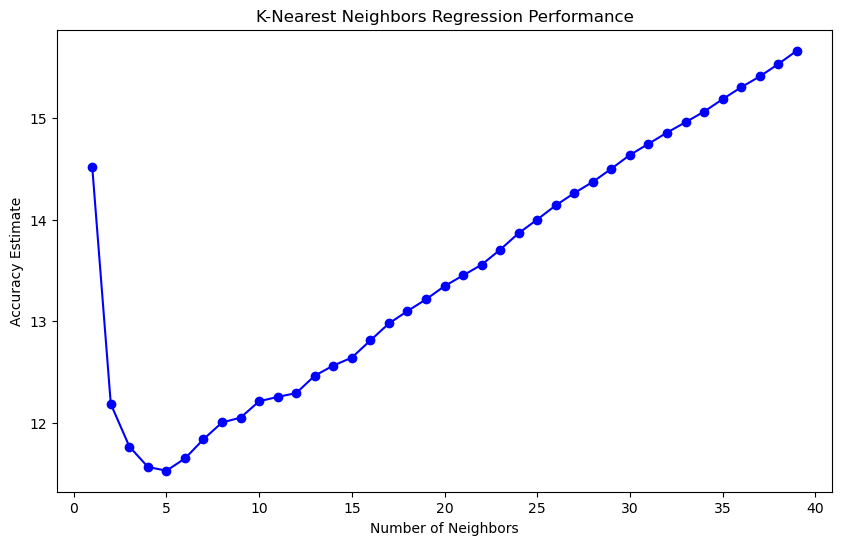

In [16]:
# Create an elbow plot
plt.figure(figsize=(10,6))

# Plot mean test scores with error bars
plt.plot(results_simplified['n_neighbors'], results_simplified['mean_test_score'], '-o', color = 'blue')

# Add labels and legend
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy Estimate')
plt.title('K-Nearest Neighbors Regression Performance')
plt.tight_layout

In [17]:
# Model Evaluation

y_pred = ttc_gridsearch.predict(X_train)

rmse = mean_squared_error(
  y_train, y_pred
)**0.5

# Calculate R2
r2 = r2_score(
    y_train,
    y_pred
)
print(f'Training RMSE is {rmse}')
print(f'Training R^2 is {r2}')

Training RMSE is 9.168102070025624
Training R^2 is 0.929794236757555


In [18]:
# Refit model with selected k 

best_knn = KNeighborsRegressor(n_neighbors= best_k)
best_knn.fit(X_train, y_train)

KNeighborsRegressor()

In [19]:
# Use model on predicted, test data and re-evaluate parameters

y_pred_test = best_knn.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

print(f"Test RMSE is {test_rmse}")
print(f"Test R² is {test_r2}")

Test RMSE is 9.0990262160855
Test R² is 0.9276714647233212


For the plots below, we got some help from ChatGPT.  

Text(0.5, 1.0, 'Actual vs. Predicted TTC Delays in Minutes')

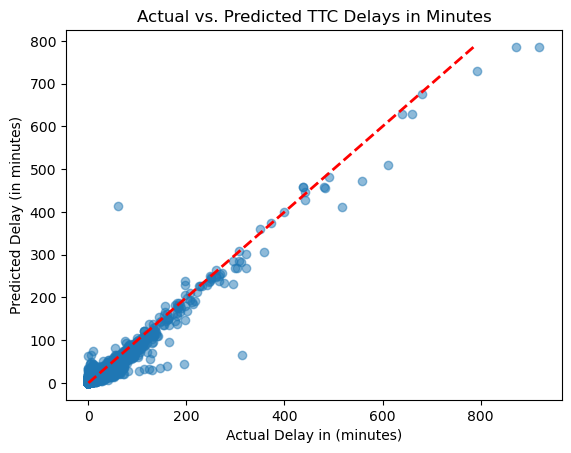

In [20]:
# Visualize train predictions.  First plot will show predicted vs actual delay times.  In a successfull regression, all the points will be on the red dotted line.

plt.scatter(y_train, y_pred, alpha = 0.5)
plt.xlabel("Actual Delay in (minutes)")
plt.ylabel("Predicted Delay (in minutes)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Adding a red dotted line at a 45 degree angle.
plt.title("Actual vs. Predicted TTC Delays in Minutes")

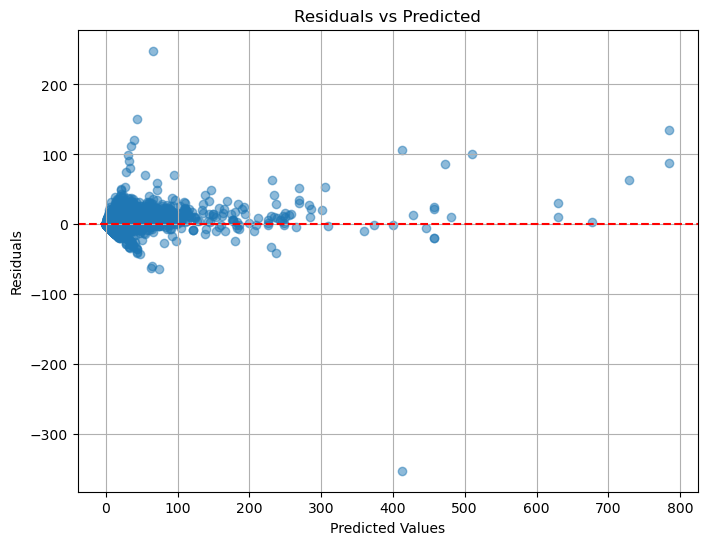

In [21]:
# Creating a residuals plot of train predictions.  In a good model, all the residuals will cluster around the zero point line.
residuals = y_train - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--') # Adding a line at zero.
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Actual vs. Predicted TTC Delays in Minutes')

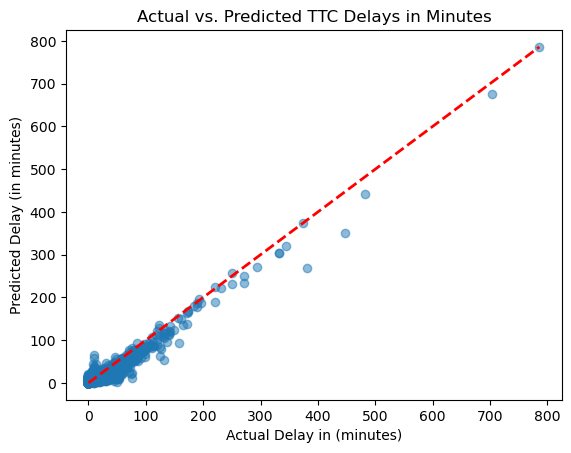

In [22]:
# Visualize test predictions.  First plot will show predicted vs actual delay times.  In a successfull regression, all the points will be on the red dotted line.

plt.scatter(y_test, y_pred_test, alpha = 0.5)
plt.xlabel("Actual Delay in (minutes)")
plt.ylabel("Predicted Delay (in minutes)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Adding a red dotted line at a 45 degree angle.
plt.title("Actual vs. Predicted TTC Delays in Minutes")

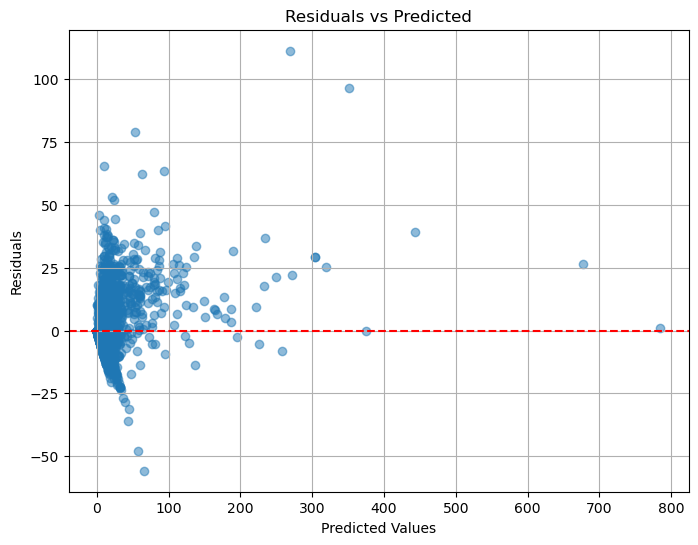

In [23]:
# Creating a residuals plot of testing predictions.  In a good model, all the residuals will cluster around the zero point line.
residuals = y_test - y_pred_test

plt.figure(figsize=(8,6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--') # Adding a line at zero.
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

### Linear Regression

In [24]:
# Will test a Linear Regression Model next.

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Check that X and y training datasets have the same number of rows.
print(X_train.shape[0])
print(y_train.shape[0])


10443
10443


In [25]:
# Create a DataFrame containing the slope (coefficients) and intercept
coefficients_df = pd.DataFrame({
    "predictor": X_train.columns,
    "slope": model.coef_,
    "intercept": [model.intercept_] * len(model.coef_)
})

# Display the coefficients DataFrame
sorted_coefficients = coefficients_df.sort_values(by = "slope", ascending=False)

r2 = model.score(X_train, y_train)
print(f'R^2 of training set is {r2}')

r2_test = model.score(X_test, y_test)
print(f'R^2 of test set is {r2_test}')

R^2 of training set is 0.9385453869889565
R^2 of test set is 0.9715473291715042


In [26]:
sorted_coefficients

,predictor,slope,intercept
25,Min Gap,33.322246,16.519866
27,Month,6.756577,16.519866
17,Incident_Rail/Switches,2.772354,16.519866
16,Incident_Overhead,2.517882,16.519866
11,Incident_General Delay,2.439986,16.519866
24,Line,0.814556,16.519866
9,Incident_Diversion,0.694263,16.519866
29,Day of Month,0.691407,16.519866
8,Incident_Collision - TTC Involved,0.632475,16.519866
5,Day_Tuesday,0.477050,16.519866


In [27]:
# Evaluate performance of training set
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("MAE:", mean_absolute_error(y_train,y_pred_train))
print("R2:", r2_score(y_train, y_pred_train))

RMSE: 8.57768910297179
MAE: 3.5764863754882446
R2: 0.9385453869889565


In [28]:
# Evaluate performance of testing set
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE:", mean_absolute_error(y_test,y_pred))
print("R2:", r2_score(y_test, y_pred))

RMSE: 5.706917586079148
MAE: 3.383126341404493
R2: 0.9715473291715042


C:\Users\natas\AppData\Local\Temp\ipykernel_17292\1332559514.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


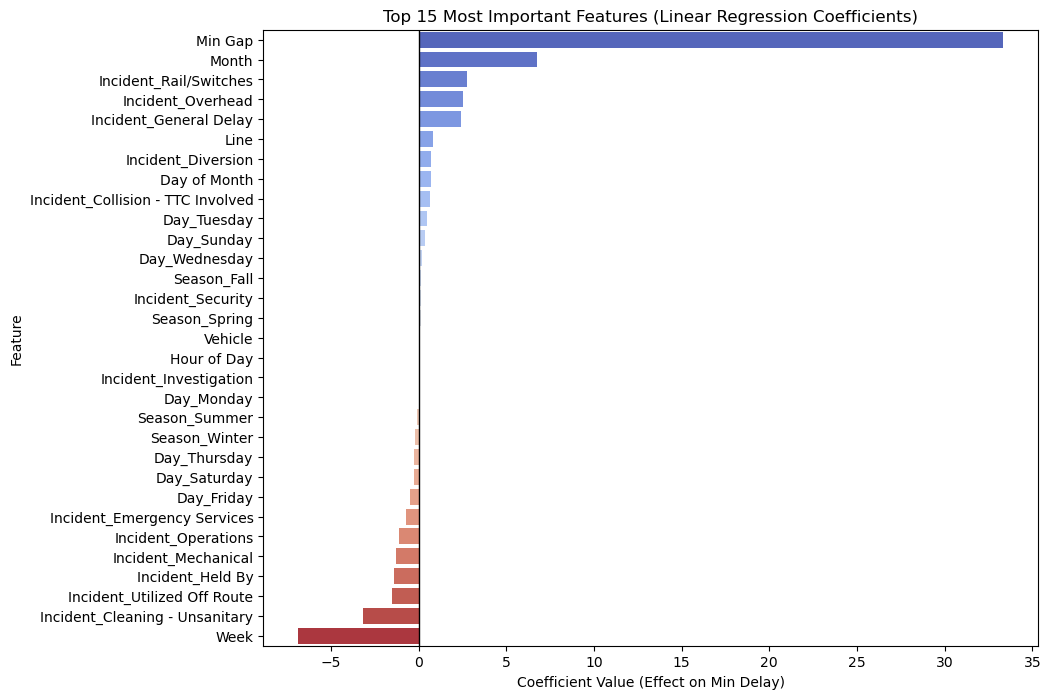

In [29]:
# Plot the relative impact (slope) of different features on the model.

plt.figure(figsize=(10,8))
sns.barplot(
    data=sorted_coefficients,
    x='slope',
    y='predictor',
    palette='coolwarm'
)
plt.title('Top 15 Most Important Features (Linear Regression Coefficients)')
plt.xlabel('Coefficient Value (Effect on Min Delay)')
plt.ylabel('Feature')
plt.axvline(0, color='black', linewidth=1)
plt.show()

Plots below recommended by ChatGPT

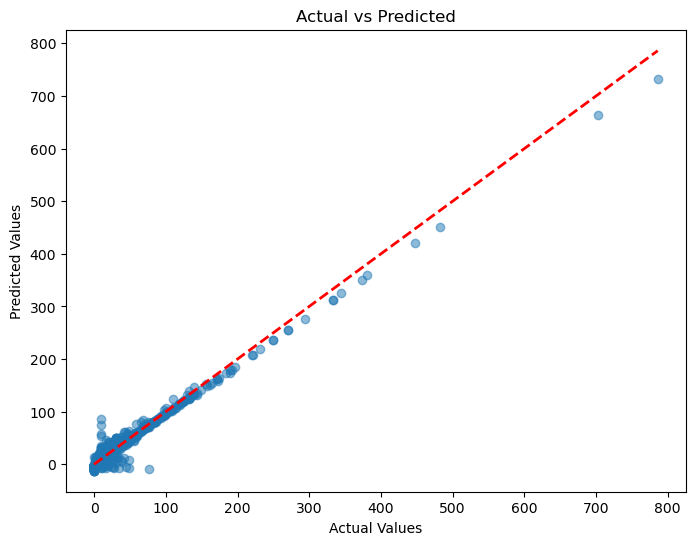

In [30]:
# Plot the actual versus predicted values.  If the model is good, all values will fall along the 45 degree reference line.

# y_test = actual values
# y_pred = predicted values from model
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # 45-degree reference line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

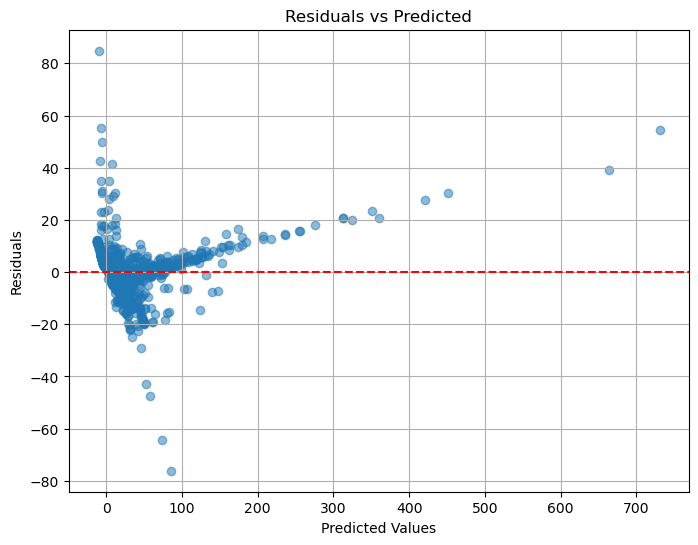

In [31]:
# Plot the residuals.  If the model is good, all values cluster around the zero reference line.

residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--') # Zero point reference line.
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

### XGB Regression

I am unfamiliar with XGB Regression, but this model was recommended by Learning Support.  Code was generated with help from ChatGPT.

In [32]:
# Initialize the Regressor

xgb = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

In [33]:
# Define a parameter grid

param_grid = {
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

In [34]:
# Perform a grid search to find best parameters (from options specified in the parameter grid)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE (lower is better)
    cv=5,      # 5-fold cross-validation
    verbose=2, # show progress
    n_jobs=-1  # parallelize
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 400],
                         'subsample': [0.7, 0.9, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [35]:
# Print the best parameters found

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)  # convert back from negative

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Best RMSE: 7.77794938010547


In [36]:
# Using the best parameters, calculate RMSE

best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 4.75


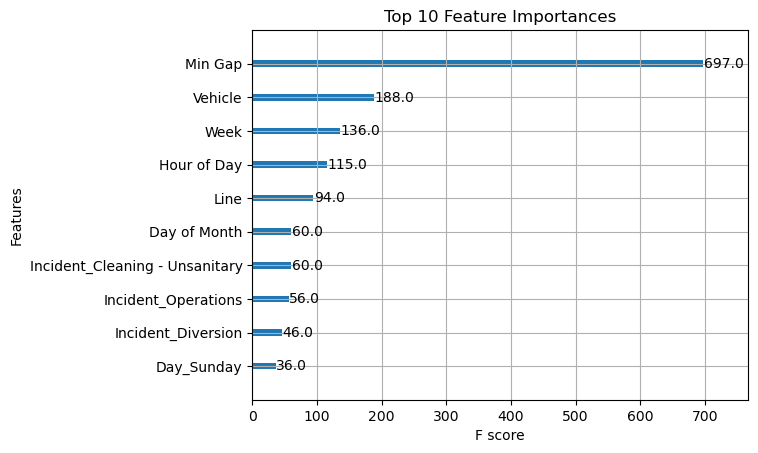

In [37]:
# Plot features of highest importance to the XGB Model.
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_xgb, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

### Using a Pipeline approach for Linear, Ridge, Lasso, Random Forest, and XGB

In [39]:
# Select features for regression
numerical_features = ['Min Gap', 'Hour of Day', 'Month', 'Week', 'Day of Month']
categorical_features = ['Line', 'Day', 'Season', 'Incident']
target = 'Min Delay'

# Create feature set and target
X = post_cleaning[numerical_features + categorical_features].copy()
y = post_cleaning[target]

In [40]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


In [41]:
# Create preprocessing pipelines for clean data
numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [42]:
# Define results dataframe

results_df = pd.DataFrame(columns=['Model', 'Train RMSE', 'Test RMSE', 'Train R^2', 'Test R^2', 'Train MAE', 'Test MAE'])

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1, max_iter=10000),  # Reduced alpha for Lasso
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'K Neighbors Regressor' : KNeighborsRegressor(),
    'XG Boost Regressor' : XGBRegressor (objective='reg:squarederror', random_state=42, n_jobs=-1)

}

# Store results
results = {}

for name, model in models.items():
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Cross-validation score
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

    # Store results
    results[name] = {
        'model': pipeline,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'predictions': y_pred_test
    }

   # Create Dataframe with Results

    new_row = {'Model': name, 'Train RMSE': train_rmse, 'Test RMSE': test_rmse, 'Train R^2': train_r2, 'Test R^2': test_r2, 
                            'Train MAE': train_mae, 'Test MAE': test_mae}
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

results_df

C:\Users\natas\AppData\Local\Temp\ipykernel_17292\2677566491.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


,Model,Train RMSE,Test RMSE,Train R^2,Test R^2,Train MAE,Test MAE
0,Linear Regression,7.332450,9.534418,0.956473,0.911780,3.421992,3.472309
1,Ridge Regression,7.332989,9.531193,0.956466,0.911839,3.423398,3.469359
2,Lasso Regression,7.465715,9.616798,0.954876,0.910249,3.639697,3.697785
3,Random Forest,2.578611,9.443788,0.994617,0.913449,0.571019,1.519783
4,K Neighbors Regressor,8.057297,11.790474,0.947442,0.865090,4.310658,5.271359
5,XG Boost Regressor,2.195080,9.248744,0.996099,0.916987,0.851804,1.776928


In [44]:
# Repeat pipeline without Min_Gap

# Define results dataframe

results_withouth_Min_Gap_df = pd.DataFrame(columns=['Model', 'Train RMSE', 'Test RMSE', 'Train R^2', 'Test R^2', 'Train MAE', 'Test MAE'])

# Select features for regression
numerical_features = ['Hour of Day', 'Month', 'Week', 'Day of Month']
categorical_features = ['Line', 'Day', 'Season', 'Incident']
target = 'Min Delay'

# Create feature set and target
X = post_cleaning[numerical_features + categorical_features].copy()
y = post_cleaning[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Create preprocessing pipelines for clean data
numerical_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define results dataframe

results_without_Min_Gap_df = pd.DataFrame(columns=['Model', 'Train RMSE', 'Test RMSE', 'Train R^2', 'Test R^2', 'Train MAE', 'Test MAE'])

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1, max_iter=10000),  # Reduced alpha for Lasso
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'K Neighbors Regressor' : KNeighborsRegressor(),
    'XG Boost Regressor' : XGBRegressor (objective='reg:squarederror', random_state=42, n_jobs=-1)

}

# Store results
results = {}

for name, model in models.items():
    
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Train model
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # Cross-validation score
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')

    # Store results
    results[name] = {
        'model': pipeline,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'predictions': y_pred_test}

    # Create Dataframe with Results

    new_row = {'Model': name, 'Train RMSE': train_rmse, 'Test RMSE': test_rmse, 'Train R^2': train_r2, 'Test R^2': test_r2, 
                            'Train MAE': train_mae, 'Test MAE': test_mae}
    results_without_Min_Gap_df = pd.concat([results_without_Min_Gap_df, pd.DataFrame([new_row])], ignore_index=True)

results_without_Min_Gap_df

C:\Users\natas\AppData\Local\Temp\ipykernel_17292\3099903194.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_without_Min_Gap_df = pd.concat([results_without_Min_Gap_df, pd.DataFrame([new_row])], ignore_index=True)


,Model,Train RMSE,Test RMSE,Train R^2,Test R^2,Train MAE,Test MAE
0,Linear Regression,33.063220,30.252114,0.114979,0.111839,12.608508,12.019547
1,Ridge Regression,33.067125,30.248685,0.114770,0.112040,12.595239,12.010280
2,Lasso Regression,33.217049,30.297198,0.106725,0.109189,12.536533,11.995789
3,Random Forest,13.746019,31.671881,0.847026,0.026518,5.006031,12.565341
4,K Neighbors Regressor,28.715307,31.575359,0.332440,0.032442,10.866418,12.530537
5,XG Boost Regressor,14.983707,34.118235,0.818239,-0.129675,7.821397,13.185548
